# Table extraction

To improve intersection points clusters selection:
density based cluster,
keep culster that a far from each other

In [1]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
from treys import Card
from termcolor import colored
from utils import eval_listof_games , debug_listof_games, save_results , load_results
import cv2
import matplotlib.pyplot as plt

from recognition_functions import *

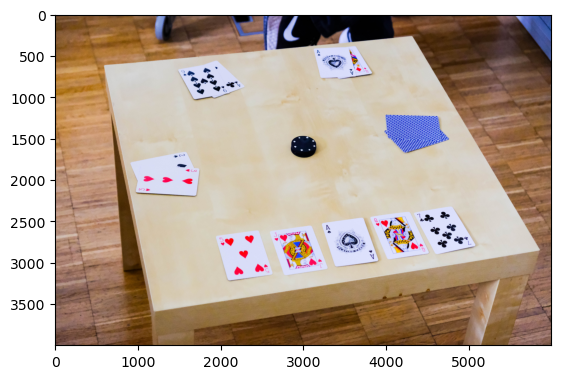

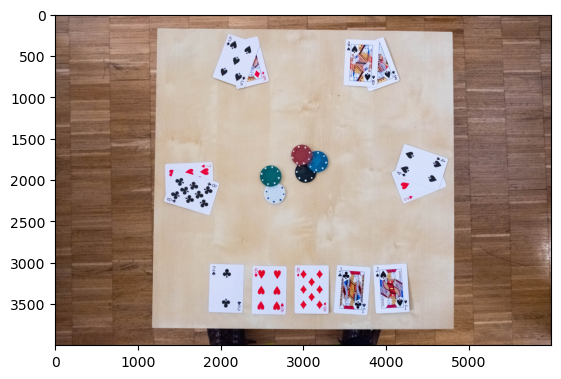

In [2]:
path_data = "data/train"
path_setup = "data/image_setup/"

file = os.path.join(path_data, f"train_{str(0).zfill(2)}.jpg")
file_xtrem = os.path.join(path_setup, "ultimate_test.jpg")

# open the image
im_xtrem = PIL.Image.open(file_xtrem)
plt.imshow(im_xtrem)
plt.show()

# open the image
im = PIL.Image.open(file)
plt.imshow(im)
plt.show()

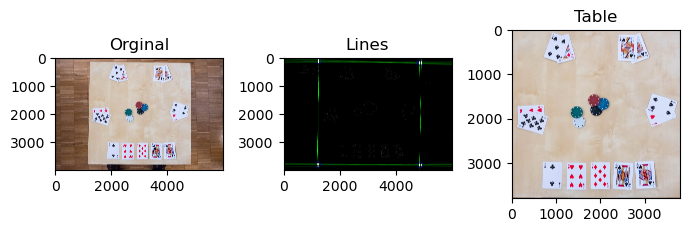

array([[[204, 165, 148],
        [201, 162, 145],
        [196, 157, 140],
        ...,
        [107,  72,  52],
        [ 96,  61,  41],
        [ 76,  41,  21]],

       [[183, 144, 127],
        [181, 142, 125],
        [185, 146, 129],
        ...,
        [109,  74,  54],
        [ 96,  61,  41],
        [ 76,  41,  21]],

       [[191, 152, 135],
        [185, 146, 129],
        [189, 150, 133],
        ...,
        [102,  67,  47],
        [ 89,  54,  34],
        [ 79,  44,  24]],

       ...,

       [[100,  69,  51],
        [ 91,  60,  42],
        [ 89,  58,  40],
        ...,
        [133,  94,  63],
        [134,  95,  64],
        [162, 123,  92]],

       [[119,  88,  70],
        [114,  83,  65],
        [104,  73,  55],
        ...,
        [132,  93,  62],
        [151, 112,  81],
        [163, 124,  93]],

       [[119,  88,  70],
        [128,  97,  79],
        [112,  81,  63],
        ...,
        [151, 112,  81],
        [125,  86,  55],
        [143, 104,  73]]

In [3]:
from table_extractor import TableExtractor
import numpy as np

tabler_extractor = TableExtractor()
tabler_extractor.extract_table(np.array(im), plot=True)

## Intermediate steps

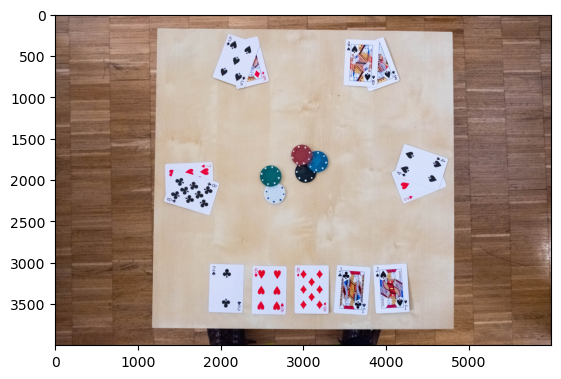

In [11]:
path_data = "data/train"

file = os.path.join(path_data, f"train_{str(0).zfill(2)}.jpg")

# open the image
im = PIL.Image.open(file)
plt.imshow(im)
plt.show()

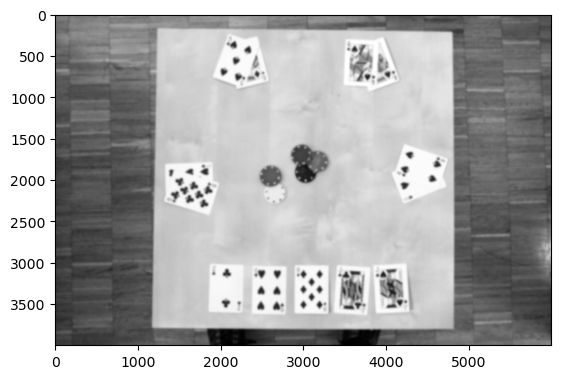

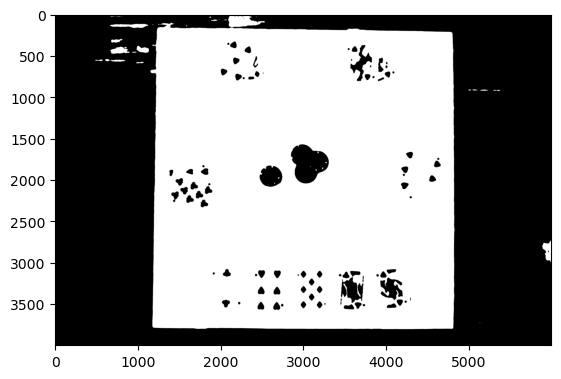

In [12]:
img = np.array(im)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(101,101),10) 

plt.imshow(blur,  cmap='gray')
plt.show()
flag, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU)

plt.imshow(thresh,  cmap='gray')
plt.show()

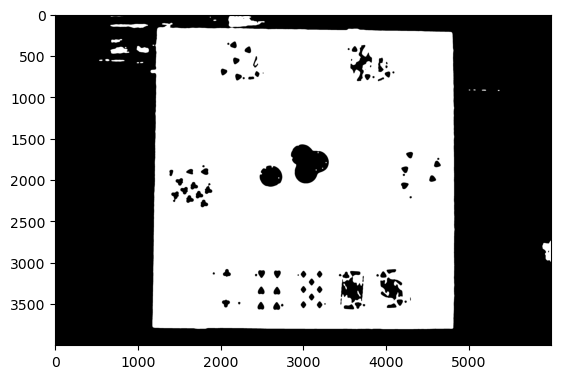

In [13]:
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel= np.ones((11,11), np.uint8))
plt.imshow(opened,  cmap='gray')
plt.show()

In [14]:
import math 
from numpy.linalg import norm

def buckets(pts, grid_step):
    buckets = dict()
    for a, b in pts:
        idx = (a//grid_step, b//grid_step)
        bucket = buckets.get(idx, [])
        bucket.append((a,b))
        buckets[idx] = bucket
    sortedKeys = sorted(buckets.keys(),key= lambda x:len(buckets[x]))
    sortedKeys.reverse()
    
    center_pts = []
    for i in range(min(len(sortedKeys), 4)):
        key = sortedKeys[i]
        b = buckets[key]
        center_point = (np.array(b).sum(axis=0) / len(b)).astype(int)
        center_pts.append(center_point)
    return center_pts
        
def drawLine(image,p1,p2):
    """
    Draw a "infinite" line on image passing by points p1 and p2
    """
    
    h , w = image.shape[:2]
    
    x1, y1 = p1
    x2, y2 = p2
    slope = line_slope(p1,p2)

    if slope!='NA':
        # extending the line to border x = 0
        px = 0
        py =- (x1 - 0) * slope + y1
        
        # extending the line to border x = width
        qx = w
        qy =- (x2 - w) * slope + y2
    else:
        # create vertical line
        px, py = x1, 0
        qx, qy = x1, h
    
    cv2.line(image, (int(px), int(py)), (int(qx), int(qy)), (0, 255, 0), 2)
    return image

def line_slope(p1,p2):
    """
    Compute the slope of the line passing by points p1 and p2
    In case of vertical line return "NA"
    """
    x1, y1 = p1
    x2, y2 = p2
    if x2!=x1:
        return((y2-y1)/(x2-x1))
    else:
        return 'NA'

def line_cosine_sim(line1, line2):
    """
    Compute the cosine similarity between line1 and line2
    """
    line1_vec = np.array((line1[0][0] - line1[1][0], line1[0][1] - line1[1][1]))
    line2_vec = np.array((line2[0][0] - line2[1][0], line2[0][1] - line2[1][1]))
    cosine = np.dot(line1_vec,line2_vec)/(norm(line1_vec)*norm(line2_vec))
    return cosine

def line_intersection(line1, line2):
    """
    Compute intersection point between line1 and line2 
    Raise an exception if the line does not intersect
    """
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def line_pipeline(img, table_size=3800):
    """
    Extract table from image using hough lines 
    """
    
    # Image preprocessing
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(101,101),10) 
    flag, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU)
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel= np.ones((11,11), np.uint8))

    # Edge detection
    dst = cv2.Canny(opened, 50, 200, None, 3)

    cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
    
    # Detect main lines
    lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)
    
    # 
    lines_pts = []
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            lines_pts.append((pt1, pt2))
            drawLine(cdst, pt1, pt2)
        
    intersection_pts = []
    for pt1_a, pt2_a in lines_pts:
        for pt1_b, pt2_b in lines_pts:
            if(abs(line_cosine_sim((pt1_a, pt2_a), (pt1_b, pt2_b))) < 0.5):
                ip_1, ip_2 = line_intersection([pt1_a, pt2_a], [pt1_b, pt2_b])
                
                if(0 <= ip_1 and ip_1 < dst.shape[1] and 0 <= ip_2 and ip_2 < dst.shape[0]):
                    intersection_pts.append((int(ip_1), int(ip_2)))
                    
    for pts in intersection_pts:
        cv2.circle(cdst, pts, radius=13, color=(255, 255, 255), thickness=5)
     
    centers_pts = buckets(intersection_pts, 500)
    #kmeans = KMeans(n_clusters=4, random_state=0).fit(np.array(intersection_pts))
    #for x,y in kmeans.cluster_centers_:
    for x,y in centers_pts:
        cv2.circle(cdst, (int(x),int(y)), radius=100, color=(0, 0,255), thickness=10)     
            
    h = np.array([ [0,0],[table_size,0],[table_size,table_size],[0,table_size] ],np.float32)
    transform = cv2.getPerspectiveTransform(rectify(np.array(centers_pts)), h)
    warp = cv2.warpPerspective(img,transform,(table_size,table_size)) 
    
    return warp, cdst
            

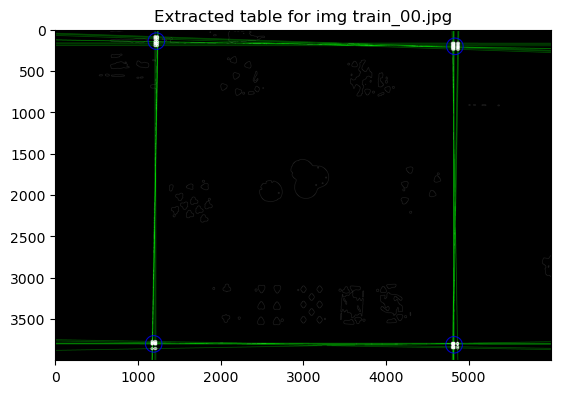

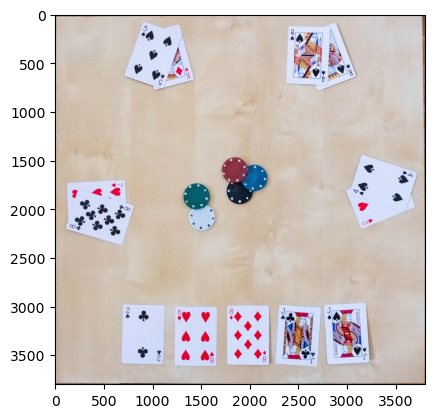

KeyboardInterrupt: 

In [15]:
for i in range(28):
    #if i not in problematic_imgs:
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    im = PIL.Image.open(file)
    plt.title(f"Extracted table for img train_{str(i).zfill(2)}.jpg")
    res, debug = line_pipeline(np.array(im))
    plt.imshow(debug)
    plt.show()
    plt.imshow(res)
    plt.show()

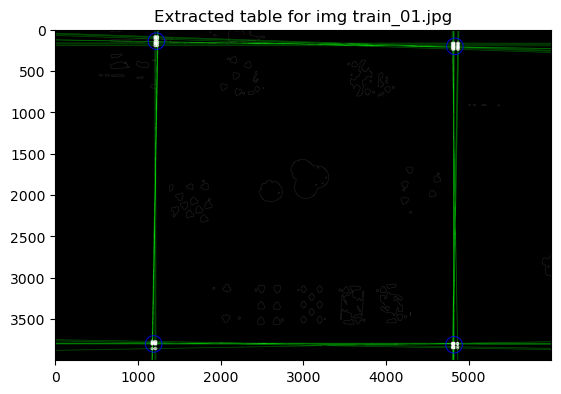

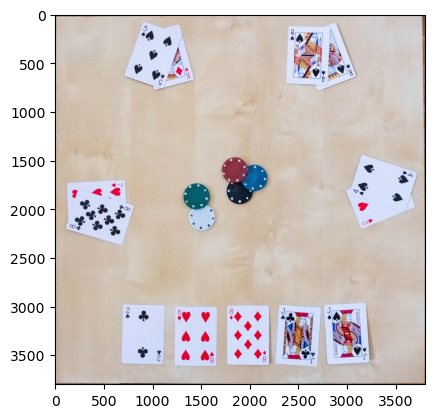

In [16]:
res, debug = line_pipeline(np.array(img))
plt.imshow(debug)
plt.show()
plt.imshow(res)
plt.show()

In [ ]:
import math 

dst = cv2.Canny(opened, 50, 200, None, 3)

plt.imshow(dst)
plt.show()
    
# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

lines = cv2.HoughLines(dst, 1, np.pi / 180 , 200, None, 0, 0)

In [ ]:
list((np.array([(1,2),(3,4)]).sum(axis=0) / 2).astype(int))

In [ ]:
if lines is not None:
    lines_pts = []
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        m = slope(pt1, pt2)
        lines_pts.append((pt1, pt2, m))
        drawLine(cdst, pt1, pt2)
        #cv2.line(cdst, pt1, pt2, (0,0,255), 5, cv2.LINE_AA)
      
    intersection_pts = []
    for pt1_a, pt2_a, slope_a in lines_pts:
        for pt1_b, pt2_b, slope_b in lines_pts:
            if(abs(slope_a - slope_b) > 10):
                ip_1, ip_2 = line_intersection([pt1_a, pt2_a], [pt1_b, pt2_b])
                
                if(0 <= ip_1 and ip_1 < dst.shape[1] and 0 <= ip_2 and ip_2 < dst.shape[0]):
                    print(ip_1, ip_2, slope_a, slope_b)
                    intersection_pts.append((int(ip_1), int(ip_2)))
                
    
    print(intersection_pts)
        
plt.imshow(cdst)
plt.show()

In [ ]:
for pts in intersection_pts:
    cv2.circle(cdst, pts, radius=13, color=(255, 255, 255), thickness=5)
    
plt.imshow(cdst)
plt.show()

In [ ]:
from sklearn.cluster import KMeans



In [ ]:
kmeans.cluster_centers_

In [ ]:


plt.imshow(cdst)
plt.show()

In [ ]:
contours, hierarchy = cv2.findContours(opened,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea,reverse=True) 

cv2.drawContours(img, contours[0], -1,(0,255,0),20)
plt.imshow(img)
plt.show()

In [ ]:
def rectify(h):
    h = h.reshape((4,2))
    hnew = np.zeros((4,2),dtype = np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h,axis = 1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]

    return hnew

table_cont = contours[0]
peri = cv2.arcLength(table_cont,True)
approx = np.array((cv2.approxPolyDP(table_cont,0.02*peri,True)))[:,0]

for a in approx:
    cv2.circle(img, (a[0], a[1]), 30,(255, 0, 0), 10)
plt.imshow(img)
plt.show()

diff = np.abs(approx[:,0]-approx[:,1])
approx = rectify(approx[np.argsort(diff)[::-1][:4]])


print(approx)

h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)
transform = cv2.getPerspectiveTransform(approx, h)
warp = cv2.warpPerspective(img,transform,(450,450))

plt.imshow(warp)
plt.show()

#rect = cv2.minAreaRect(contours[2])
#r = cv2.cv.BoxPoints(rect)

In [ ]:
rot_rect = cv2.minAreaRect(contours[0])
box = np.array(cv2.boundingRect(contours[0]))
print(box)
box = cv2.boxPoints(rot_rect)
print(box)

h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)
transform = cv2.getPerspectiveTransform(box, h)
warp = cv2.warpPerspective(img,transform,(450,450))

plt.imshow(warp)
plt.show()

In [ ]:
totalLabels, label_ids, values, centroid = cv2.connectedComponentsWithStats(opened)

for i in range(1, totalLabels):
    area = values[i, cv2.CC_STAT_AREA] 
 
    if (area > 5000000):
       
        # Labels stores all the IDs of the components on the each pixel
        # It has the same dimension as the threshold
        # So we'll check the component
        # then convert it to 255 value to mark it white
        componentMask = (label_ids == i).astype("uint8") * 255
         
        plt.imshow(componentMask,  cmap='gray')
        plt.show()
        print(componentMask.shape)
        # Creating the Final output mask